"Coctel party effect" prestavlja sposobnost mozga da obrati paznju na odredjeni signal(efekat selekticvne paznje u mozgu ),odnosno  da se u bucnoj sobi moze usresrediti na odredjeni razgovor (zvuk). Mozak ima sposobnost da razdvoji razlicite zvukove u razlicite tokove, a zatim odluci koji od tih tokova su najrelevantniji.'Ovaj efekat omogucava ljudima da se prilagode jednom glasuz ,a zanemare sve ostale. 
Takodje moze opisati slican efekat kada u prostoriji punoj glasova mozemo primetiti neku nama vazniju recenicu npr. necije ime.

Nemogucnost racunara da razvoji zvukove na ovaj nacin se naziva " coctel party problem  ".
Do resenja ovoga problema je moguce doci koriscenjem tehnike dekompozicije linearnih mesavina signala u njihove komponente(ICA).

Prvo je potrebno uvesti potrebne biblioteke: 

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline



Generativni model ICA

ICA je bazirana na generativnom modelu . Ovo znaci da predpostavlja osnovni proces koji generise posmatrane podatke.
ICA model predpostavlja da su neki nezavisni signali linearni kombinovani pomocnom  matricom A.

                                            x=As

Izdvajanje pojedinacnih signala 

Gornja jednacina podrazumeva da ako invertujemo A i pomnozimo sa posmatranim signalom k,izvdvojicemo nase izvore :

                                          W=A^{-1}
                                            s=xW 
ICA algoritam treba da proceni W.  ć č š

U funckiji Center se vrši oduzimanje srednje vrednosti od ulaznog signala, da bi se kasnije lakše primenio ICA.
Cilj u funkciji whiten je linearno transformise signal tako da bi se izbegle potencijalne korelacije između signala. 

In [2]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X) 
    
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    
    # Project onto whitening matrix
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM

Implementiranje  ICA algoritma:

Uslov za rad ICA algoritma je da izvorni signali ne budu Gausovi. Stoga bi rezultat ICA algoritma trebao vratiti rezultate koji nisu Gausovi.
Jedan od nacina je koriscenjem metode Kurtosis odnosno merila tačnosti distribucije slucajne promeljive.
Za aktuelni algoritam koristimo g i g' koji su izvedeni iz f(u).

                                    f(u)=logcosh(u)
                                    g(u)=tanh(u)
                                    g'(u)=1-tanh^2(u)

Ove jednacine bice koriscenje u donjem delu ICA algoritma koji je zasnovan na šemi interacije staticnih-tacaka.

                                    for 1 do broja komponenti:
                                    wp = random inicijalizacija
                                    while wp nije < trash:
                                    wp =(1/n)*(Xg*(W^{T}*X) - g'(W^{T}*X)*W)
                                    wp = wp-SUM_{j=1}^{p-1}(wp^{T}*wj)*wj
                                    wp = wp/||wp||
                                    W=[w1,...,wc]
                                    
Dakle prema gore navedenom ono sto moramo da uradimo je da nasumično pretpostavimo vrednost svake komponente.
Vektorski proizvod slučajnih vrednosti i mešanih signala se prenosi u funkcije g i g'.Zatim oduzimamo rezultate  g' i g ,a posle račumamo srednju vrednost.
Rezultat je nova vrednost vektora.Dalje cemo direktno deliti vrednost vektora po njegovoj normi i ponavljati sve dok vrensot ne prestane da se menja.
Problem je što bi u  interaciji za drugu komponentu mogli indetifikovati istu komponentu kao u prvoj interaciji.
Da bi smo resili ovaj problem moramo da smanjimo povezanost izmedju signala novih vrednosti od prethondno dobijenih vrednosti.
Ovo se dogadja u koraku izmedju azuriranja vrednosti i podele na njihovu normu .


In [7]:
def Ica(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime 
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Update weights
                w = wNew
                
                # Update counter
                i += 1

            W[c, :] = w.T
    return W

Kreiranje početnog signala
Počećemo kreiranjem nezavisnih signala koji će se mesati uz pomoc matrice A.
Izvrsićemo izračunavanje vektorski proizvod signala S sa A,nakon čega cemo dobiti tri linearne kombinacije ovih izvornih signala.
Učitavamo 3 zvuka, koji će se zatim ubaciti u matrici S.

In [8]:
# Broj uzirka
ns = np.linspace(0, 200, 150000)

# Ucitavanje pesmama
Fs, data = read('out4.wav')

#data = data[:,0]
delilac = len(data)
data = data / delilac

Fs2, data2 = read('out5.wav')

data2 = data2[:,0]
delilac2 = len(data2)
data2 = data2 / delilac2

Fs3, data3 = read('out6.wav')

data3 = data3[:,0]
delilac3 = len(data3)
data3 = data3 / delilac3

# Izvorna matrica
S = np.array([data, 
              data2,
              data3]).T

# Pomocna martica
A = np.array([[0.5, 1, 0.2], 
              [1, 0.5, 0.4], 
              [0.5, 0.8, 1]])

# Matrica sa pomesanim signalima
X = S.dot(A).T

In [9]:
Audio(data, rate=Fs)

In [10]:
Audio(data2, rate=Fs)

In [11]:
Audio(data3, rate=Fs)

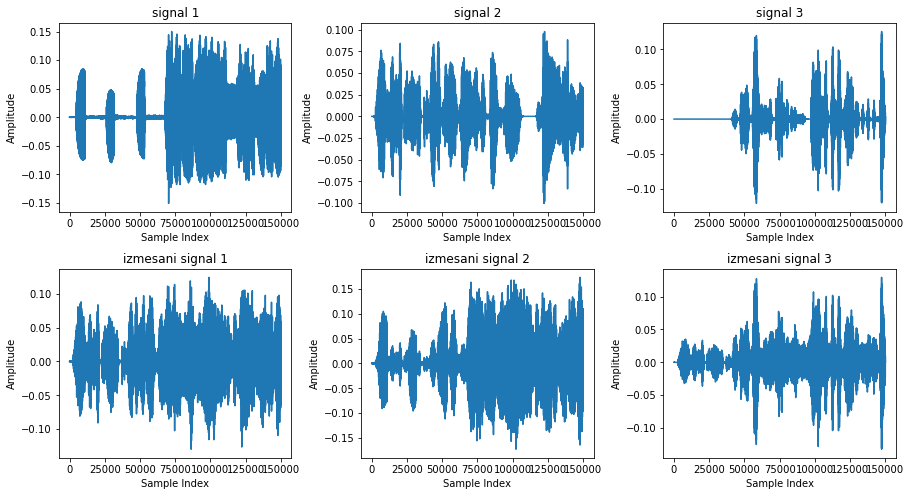

In [12]:
fig, ax = plt.subplots(2, 3, figsize=[15, 8])

ax[0,0].plot(data)
ax[0,0].set_xlabel('Sample Index')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_title('signal 1')

ax[0,1].plot(data2)
ax[0,1].set_xlabel('Sample Index')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].set_title('signal 2')

ax[0,2].plot(data3)
ax[0,2].set_xlabel('Sample Index')
ax[0,2].set_ylabel('Amplitude')
ax[0,2].set_title('signal 3')

ax[1,0].plot(X[0])
ax[1,0].set_xlabel('Sample Index')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_title('izmesani signal 1')

ax[1,1].plot(X[1])
ax[1,1].set_xlabel('Sample Index')
ax[1,1].set_ylabel('Amplitude')
ax[1,1].set_title('izmesani signal 2')

ax[1,2].plot(X[2])
ax[1,2].set_xlabel('Sample Index')
ax[1,2].set_ylabel('Amplitude')
ax[1,2].set_title('izmesani signal 3')

plt.subplots_adjust(wspace=.3, hspace=0.3)

plt.show()

In [13]:
Audio(X[0], rate=Fs)

In [14]:
Audio(X[1], rate=Fs)

In [15]:
Audio(X[2], rate=Fs)

In [16]:


# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)




# Check if covariance of whitened matrix equals identity matrix
print(np.round(covariance(Xw)))



[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]


In [17]:
W = Ica(Xw,  alpha=1)

#Un-mix signals using 
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

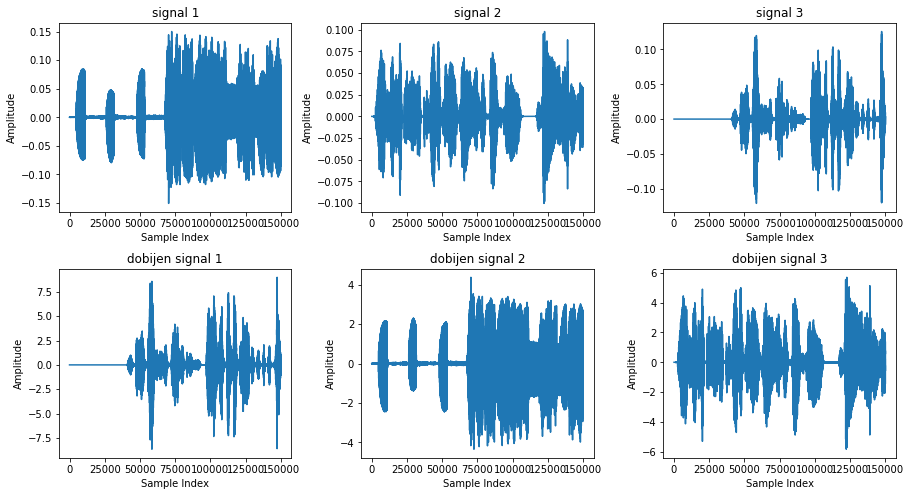

In [18]:
fig, ax = plt.subplots(2, 3, figsize=[15, 8])

ax[0,0].plot(data)
ax[0,0].set_xlabel('Sample Index')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_title('signal 1')

ax[0,1].plot(data2)
ax[0,1].set_xlabel('Sample Index')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].set_title('signal 2')

ax[0,2].plot(data3)
ax[0,2].set_xlabel('Sample Index')
ax[0,2].set_ylabel('Amplitude')
ax[0,2].set_title('signal 3')

ax[1,0].plot(unMixed.T[0])
ax[1,0].set_xlabel('Sample Index')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_title('dobijen signal 1')

ax[1,1].plot(unMixed.T[1])
ax[1,1].set_xlabel('Sample Index')
ax[1,1].set_ylabel('Amplitude')
ax[1,1].set_title('dobijen signal 2')

ax[1,2].plot(unMixed.T[2])
ax[1,2].set_xlabel('Sample Index')
ax[1,2].set_ylabel('Amplitude')
ax[1,2].set_title('dobijen signal 3')

plt.subplots_adjust(wspace=.3, hspace=0.3)

plt.show()

In [19]:
Audio(unMixed.T[0], rate=Fs)

In [20]:
Audio(unMixed.T[1], rate=Fs)

In [21]:
Audio(unMixed.T[2], rate=Fs)